In [2]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
train_data.shape
(404, 13)
test_data.shape
(102, 13)


(102, 13)

In [4]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [6]:
from keras import models
from keras import layers
import numpy as np

# For Reusability, model is defined as a function.

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],))) # number of features (13) are used as vector in input shape
  model.add(layers.Dense(64, activation = 'relu'))
  model.add(layers.Dense(1)) # no activation function
  model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
  return model

In [7]:
k = 4
num_val_samples = len(train_data) // 4
num_epochs = 100
all_scores = []

for i in range(k):
  print('processing fold # ', i)
  # prepare the validation data: data from partition # k
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  
  # prepare the training data: data from data - k
  partial_train_data = np.concatenate(                    
      [train_data[:i * num_val_samples],
      train_data[(i + 1 ) * num_val_samples:]],
  axis = 0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
      train_targets[(i + 1 ) * num_val_samples:]],
  axis = 0)
  # Build the Keras Models (already commpiled)
  model = build_model()
  # Train the model (in silence mode, verbose = 0)
  model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 1, verbose = 1)
  # Evaluate the model on the validation data
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
  all_scores.append(val_mae)

processing fold #  0
Epoch 1/100
303/303 [==============================] - 1s 2ms/step - loss: 202.3768 - mean_absolute_error: 10.7720
Epoch 2/100
303/303 [==============================] - 0s 2ms/step - loss: 30.2339 - mean_absolute_error: 3.8335
Epoch 3/100
303/303 [==============================] - 0s 1ms/step - loss: 21.3076 - mean_absolute_error: 3.1752
Epoch 4/100
303/303 [==============================] - 0s 1ms/step - loss: 18.2485 - mean_absolute_error: 2.8962
Epoch 5/100
303/303 [==============================] - 0s 1ms/step - loss: 16.6298 - mean_absolute_error: 2.6634
Epoch 6/100
303/303 [==============================] - 0s 1ms/step - loss: 15.4707 - mean_absolute_error: 2.5690
Epoch 7/100
303/303 [==============================] - 0s 1ms/step - loss: 14.2055 - mean_absolute_error: 2.5331
Epoch 8/100
303/303 [==============================] - 0s 1ms/step - loss: 13.8280 - mean_absolute_error: 2.4202
Epoch 9/100
303/303 [==============================] - 0s 1ms/step - loss

303/303 [==============================] - 0s 1ms/step - loss: 6.5958 - mean_absolute_error: 1.6511
Epoch 46/100
303/303 [==============================] - 0s 1ms/step - loss: 7.1091 - mean_absolute_error: 1.6746
Epoch 47/100
303/303 [==============================] - 0s 1ms/step - loss: 7.2578 - mean_absolute_error: 1.6861
Epoch 48/100
303/303 [==============================] - 0s 1ms/step - loss: 7.3561 - mean_absolute_error: 1.6959
Epoch 49/100
303/303 [==============================] - 0s 1ms/step - loss: 6.8652 - mean_absolute_error: 1.6629
Epoch 50/100
303/303 [==============================] - 0s 1ms/step - loss: 6.8403 - mean_absolute_error: 1.6550
Epoch 51/100
303/303 [==============================] - 0s 1ms/step - loss: 6.9924 - mean_absolute_error: 1.6501
Epoch 52/100
303/303 [==============================] - 0s 1ms/step - loss: 6.5814 - mean_absolute_error: 1.6207
Epoch 53/100
303/303 [==============================] - 0s 1ms/step - loss: 6.6986 - mean_absolute_error: 1.6

303/303 [==============================] - 0s 1ms/step - loss: 3.3674 - mean_absolute_error: 1.2634
Epoch 90/100
303/303 [==============================] - 0s 1ms/step - loss: 3.5890 - mean_absolute_error: 1.3663
Epoch 91/100
303/303 [==============================] - 0s 1ms/step - loss: 3.4864 - mean_absolute_error: 1.3313
Epoch 92/100
303/303 [==============================] - 0s 1ms/step - loss: 3.0897 - mean_absolute_error: 1.2951
Epoch 93/100
303/303 [==============================] - 0s 1ms/step - loss: 3.2211 - mean_absolute_error: 1.2850
Epoch 94/100
303/303 [==============================] - 0s 1ms/step - loss: 3.2154 - mean_absolute_error: 1.3276
Epoch 95/100
303/303 [==============================] - 0s 1ms/step - loss: 3.2341 - mean_absolute_error: 1.2688
Epoch 96/100
303/303 [==============================] - 0s 1ms/step - loss: 3.0529 - mean_absolute_error: 1.2840
Epoch 97/100
303/303 [==============================] - 0s 1ms/step - loss: 2.8846 - mean_absolute_error: 1.2

In [8]:
all_scores

[2.090378675130334, 2.200277791164889, 2.9694182919983816, 2.3763747634273944]

In [9]:
np.mean(all_scores)

2.40911238043025

# Updating the Epochs

In [11]:
k = 4
num_val_samples = len(train_data) // 4
num_epochs = 500
all_mae_histories = []

for i in range(k):
  print('processing fold # ', i)
  # prepare the validation data: data from partition # k
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  
  # prepare the training data: data from data - k
  partial_train_data = np.concatenate(                    
      [train_data[:i * num_val_samples],
      train_data[(i + 1 ) * num_val_samples:]],
  axis = 0)
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples],
      train_targets[(i + 1 ) * num_val_samples:]],
  axis = 0)
  # Build the Keras Models (already commpiled)
  model = build_model()
  # Train the model (in silence mode, verbose = 0)
  history = model.fit(partial_train_data, partial_train_targets, validation_data = (val_data, val_targets), epochs = num_epochs, batch_size = 1, verbose = 1)
  mae_history = history.history['val_mean_absolute_error']
  all_mae_histories.append(mae_history)

processing fold #  0
Train on 303 samples, validate on 101 samples
Epoch 1/500
303/303 [==============================] - 1s 3ms/step - loss: 157.7442 - mean_absolute_error: 9.4913 - val_loss: 37.5444 - val_mean_absolute_error: 4.1305
Epoch 2/500
303/303 [==============================] - 1s 2ms/step - loss: 29.0979 - mean_absolute_error: 3.7471 - val_loss: 21.5624 - val_mean_absolute_error: 2.8220
Epoch 3/500
303/303 [==============================] - 1s 2ms/step - loss: 20.4908 - mean_absolute_error: 3.0738 - val_loss: 15.4187 - val_mean_absolute_error: 2.4263
Epoch 4/500
303/303 [==============================] - 0s 2ms/step - loss: 17.7153 - mean_absolute_error: 2.7895 - val_loss: 16.8332 - val_mean_absolute_error: 2.6712
Epoch 5/500
303/303 [==============================] - 1s 2ms/step - loss: 16.1924 - mean_absolute_error: 2.6587 - val_loss: 12.0660 - val_mean_absolute_error: 2.4164
Epoch 6/500
303/303 [==============================] - 1s 2ms/step - loss: 14.7650 - mean_absolut

Epoch 50/500
303/303 [==============================] - 0s 2ms/step - loss: 6.7763 - mean_absolute_error: 1.6891 - val_loss: 7.4304 - val_mean_absolute_error: 2.0113
Epoch 51/500
303/303 [==============================] - 0s 2ms/step - loss: 6.4959 - mean_absolute_error: 1.6804 - val_loss: 7.8571 - val_mean_absolute_error: 2.1288
Epoch 52/500
303/303 [==============================] - 0s 2ms/step - loss: 6.5225 - mean_absolute_error: 1.6837 - val_loss: 6.9320 - val_mean_absolute_error: 1.7632
Epoch 53/500
303/303 [==============================] - 0s 2ms/step - loss: 6.1677 - mean_absolute_error: 1.7266 - val_loss: 8.3822 - val_mean_absolute_error: 2.3082
Epoch 54/500
303/303 [==============================] - 0s 2ms/step - loss: 6.4306 - mean_absolute_error: 1.6832 - val_loss: 8.0909 - val_mean_absolute_error: 1.9081
Epoch 55/500
303/303 [==============================] - 0s 2ms/step - loss: 6.1244 - mean_absolute_error: 1.6611 - val_loss: 7.4989 - val_mean_absolute_error: 1.8636
Epoc

303/303 [==============================] - 0s 2ms/step - loss: 3.5281 - mean_absolute_error: 1.3001 - val_loss: 8.4530 - val_mean_absolute_error: 2.2345
Epoch 149/500
303/303 [==============================] - 0s 2ms/step - loss: 3.4832 - mean_absolute_error: 1.2606 - val_loss: 7.4050 - val_mean_absolute_error: 1.9775
Epoch 150/500
303/303 [==============================] - 0s 2ms/step - loss: 3.7289 - mean_absolute_error: 1.3252 - val_loss: 11.3782 - val_mean_absolute_error: 2.2741
Epoch 151/500
303/303 [==============================] - 0s 2ms/step - loss: 3.2180 - mean_absolute_error: 1.2797 - val_loss: 8.9313 - val_mean_absolute_error: 2.2254
Epoch 152/500
303/303 [==============================] - 0s 2ms/step - loss: 3.3398 - mean_absolute_error: 1.3212 - val_loss: 9.8200 - val_mean_absolute_error: 2.3778
Epoch 153/500
303/303 [==============================] - 0s 2ms/step - loss: 2.9911 - mean_absolute_error: 1.2187 - val_loss: 7.0189 - val_mean_absolute_error: 1.9948
Epoch 154/5

Epoch 246/500
303/303 [==============================] - 0s 2ms/step - loss: 1.9506 - mean_absolute_error: 1.0542 - val_loss: 8.7084 - val_mean_absolute_error: 1.9458
Epoch 247/500
303/303 [==============================] - 0s 2ms/step - loss: 2.0578 - mean_absolute_error: 1.0141 - val_loss: 9.2980 - val_mean_absolute_error: 2.2893
Epoch 248/500
303/303 [==============================] - 1s 2ms/step - loss: 1.9221 - mean_absolute_error: 0.9893 - val_loss: 9.2051 - val_mean_absolute_error: 2.2764
Epoch 249/500
303/303 [==============================] - 1s 2ms/step - loss: 1.9322 - mean_absolute_error: 0.9984 - val_loss: 10.7972 - val_mean_absolute_error: 2.4495
Epoch 250/500
303/303 [==============================] - 0s 2ms/step - loss: 2.1200 - mean_absolute_error: 1.0747 - val_loss: 7.6044 - val_mean_absolute_error: 2.0098
Epoch 251/500
303/303 [==============================] - 1s 2ms/step - loss: 1.7852 - mean_absolute_error: 0.9534 - val_loss: 9.3827 - val_mean_absolute_error: 2.12

Epoch 295/500
303/303 [==============================] - 1s 2ms/step - loss: 2.0429 - mean_absolute_error: 0.9522 - val_loss: 8.3674 - val_mean_absolute_error: 2.0889
Epoch 296/500
303/303 [==============================] - 1s 2ms/step - loss: 1.6759 - mean_absolute_error: 0.9265 - val_loss: 8.7413 - val_mean_absolute_error: 2.1374
Epoch 297/500
303/303 [==============================] - 1s 2ms/step - loss: 1.7875 - mean_absolute_error: 0.9458 - val_loss: 8.6587 - val_mean_absolute_error: 2.1157
Epoch 298/500
303/303 [==============================] - 1s 2ms/step - loss: 1.7631 - mean_absolute_error: 0.9427 - val_loss: 9.4624 - val_mean_absolute_error: 2.1919
Epoch 299/500
303/303 [==============================] - 1s 2ms/step - loss: 1.6149 - mean_absolute_error: 0.9094 - val_loss: 9.8647 - val_mean_absolute_error: 2.1135
Epoch 300/500
303/303 [==============================] - 1s 2ms/step - loss: 1.8626 - mean_absolute_error: 0.9645 - val_loss: 8.3868 - val_mean_absolute_error: 2.104

303/303 [==============================] - 1s 2ms/step - loss: 1.4851 - mean_absolute_error: 0.9141 - val_loss: 8.6888 - val_mean_absolute_error: 2.0741
Epoch 345/500
303/303 [==============================] - 1s 2ms/step - loss: 1.4407 - mean_absolute_error: 0.8270 - val_loss: 8.9337 - val_mean_absolute_error: 2.1114
Epoch 346/500
303/303 [==============================] - 1s 2ms/step - loss: 1.3407 - mean_absolute_error: 0.8375 - val_loss: 9.0550 - val_mean_absolute_error: 2.2347
Epoch 347/500
303/303 [==============================] - 1s 2ms/step - loss: 1.3156 - mean_absolute_error: 0.8505 - val_loss: 11.4461 - val_mean_absolute_error: 2.4922
Epoch 348/500
303/303 [==============================] - 1s 2ms/step - loss: 1.5736 - mean_absolute_error: 0.9202 - val_loss: 7.8776 - val_mean_absolute_error: 2.0191
Epoch 349/500
303/303 [==============================] - 1s 2ms/step - loss: 1.4575 - mean_absolute_error: 0.8651 - val_loss: 8.1089 - val_mean_absolute_error: 2.0371
Epoch 350/5

Epoch 442/500
303/303 [==============================] - 0s 2ms/step - loss: 1.1477 - mean_absolute_error: 0.7656 - val_loss: 8.2222 - val_mean_absolute_error: 2.0950
Epoch 443/500
303/303 [==============================] - 0s 2ms/step - loss: 0.9531 - mean_absolute_error: 0.7151 - val_loss: 7.4464 - val_mean_absolute_error: 2.0280
Epoch 444/500
303/303 [==============================] - 0s 2ms/step - loss: 1.1691 - mean_absolute_error: 0.7965 - val_loss: 8.2685 - val_mean_absolute_error: 2.0670
Epoch 445/500
303/303 [==============================] - 0s 2ms/step - loss: 1.0892 - mean_absolute_error: 0.7570 - val_loss: 7.2341 - val_mean_absolute_error: 1.9717
Epoch 446/500
303/303 [==============================] - 0s 2ms/step - loss: 1.1179 - mean_absolute_error: 0.7614 - val_loss: 8.9160 - val_mean_absolute_error: 2.1920
Epoch 447/500
303/303 [==============================] - 0s 2ms/step - loss: 1.2733 - mean_absolute_error: 0.7671 - val_loss: 7.8843 - val_mean_absolute_error: 1.957

303/303 [==============================] - 0s 2ms/step - loss: 0.9051 - mean_absolute_error: 0.6691 - val_loss: 7.2602 - val_mean_absolute_error: 1.9628
Epoch 492/500
303/303 [==============================] - 0s 2ms/step - loss: 0.9703 - mean_absolute_error: 0.6917 - val_loss: 10.7436 - val_mean_absolute_error: 2.3240
Epoch 493/500
303/303 [==============================] - 0s 2ms/step - loss: 0.9448 - mean_absolute_error: 0.7039 - val_loss: 9.2868 - val_mean_absolute_error: 2.2267
Epoch 494/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0467 - mean_absolute_error: 0.7201 - val_loss: 7.7681 - val_mean_absolute_error: 2.0550
Epoch 495/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9792 - mean_absolute_error: 0.7042 - val_loss: 8.9626 - val_mean_absolute_error: 2.2026
Epoch 496/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0137 - mean_absolute_error: 0.6920 - val_loss: 8.3082 - val_mean_absolute_error: 2.1038
Epoch 497/5

Epoch 40/500
303/303 [==============================] - 0s 2ms/step - loss: 7.1406 - mean_absolute_error: 1.7857 - val_loss: 8.9261 - val_mean_absolute_error: 2.2255
Epoch 41/500
303/303 [==============================] - 0s 2ms/step - loss: 7.2461 - mean_absolute_error: 1.7372 - val_loss: 9.2559 - val_mean_absolute_error: 2.2263
Epoch 42/500
303/303 [==============================] - 0s 2ms/step - loss: 7.7820 - mean_absolute_error: 1.7424 - val_loss: 9.4230 - val_mean_absolute_error: 2.2982
Epoch 43/500
303/303 [==============================] - 0s 2ms/step - loss: 7.6833 - mean_absolute_error: 1.7171 - val_loss: 10.3154 - val_mean_absolute_error: 2.4255
Epoch 44/500
303/303 [==============================] - 0s 2ms/step - loss: 6.7379 - mean_absolute_error: 1.6787 - val_loss: 12.2015 - val_mean_absolute_error: 2.7053
Epoch 45/500
303/303 [==============================] - 0s 2ms/step - loss: 7.2765 - mean_absolute_error: 1.7533 - val_loss: 8.6872 - val_mean_absolute_error: 2.1917
Ep

Epoch 138/500
303/303 [==============================] - 0s 2ms/step - loss: 2.8432 - mean_absolute_error: 1.1437 - val_loss: 14.8717 - val_mean_absolute_error: 2.7839
Epoch 139/500
303/303 [==============================] - 0s 2ms/step - loss: 2.8275 - mean_absolute_error: 1.0767 - val_loss: 12.4368 - val_mean_absolute_error: 2.4325
Epoch 140/500
303/303 [==============================] - 0s 2ms/step - loss: 2.5870 - mean_absolute_error: 1.0517 - val_loss: 13.2829 - val_mean_absolute_error: 2.3799
Epoch 141/500
303/303 [==============================] - 0s 2ms/step - loss: 2.6474 - mean_absolute_error: 1.1093 - val_loss: 12.9191 - val_mean_absolute_error: 2.4799
Epoch 142/500
303/303 [==============================] - 0s 2ms/step - loss: 2.4614 - mean_absolute_error: 1.0132 - val_loss: 15.2092 - val_mean_absolute_error: 2.7234
Epoch 143/500
303/303 [==============================] - 0s 2ms/step - loss: 2.6689 - mean_absolute_error: 1.0602 - val_loss: 16.6007 - val_mean_absolute_error:

Epoch 187/500
303/303 [==============================] - 0s 2ms/step - loss: 2.0685 - mean_absolute_error: 1.0020 - val_loss: 13.4903 - val_mean_absolute_error: 2.4857
Epoch 188/500
303/303 [==============================] - 0s 1ms/step - loss: 1.7651 - mean_absolute_error: 0.9482 - val_loss: 16.6172 - val_mean_absolute_error: 2.7582
Epoch 189/500
303/303 [==============================] - 0s 1ms/step - loss: 2.2160 - mean_absolute_error: 1.0409 - val_loss: 12.5196 - val_mean_absolute_error: 2.5346
Epoch 190/500
303/303 [==============================] - 0s 2ms/step - loss: 1.8048 - mean_absolute_error: 0.9767 - val_loss: 11.5549 - val_mean_absolute_error: 2.4303
Epoch 191/500
303/303 [==============================] - 0s 2ms/step - loss: 1.8958 - mean_absolute_error: 0.9757 - val_loss: 12.2659 - val_mean_absolute_error: 2.4855
Epoch 192/500
303/303 [==============================] - 0s 2ms/step - loss: 1.6620 - mean_absolute_error: 0.9390 - val_loss: 15.1783 - val_mean_absolute_error:

Epoch 236/500
303/303 [==============================] - 0s 2ms/step - loss: 1.6305 - mean_absolute_error: 0.9343 - val_loss: 24.9311 - val_mean_absolute_error: 3.3184
Epoch 237/500
303/303 [==============================] - 0s 2ms/step - loss: 1.6277 - mean_absolute_error: 0.9338 - val_loss: 17.8621 - val_mean_absolute_error: 2.8792
Epoch 238/500
303/303 [==============================] - 0s 2ms/step - loss: 1.5512 - mean_absolute_error: 0.8913 - val_loss: 24.1844 - val_mean_absolute_error: 3.0486
Epoch 239/500
303/303 [==============================] - 0s 2ms/step - loss: 1.6255 - mean_absolute_error: 0.8869 - val_loss: 22.3530 - val_mean_absolute_error: 3.0712
Epoch 240/500
303/303 [==============================] - 0s 2ms/step - loss: 1.7075 - mean_absolute_error: 0.9093 - val_loss: 16.1576 - val_mean_absolute_error: 2.8099
Epoch 241/500
303/303 [==============================] - 0s 2ms/step - loss: 1.4862 - mean_absolute_error: 0.8861 - val_loss: 14.8015 - val_mean_absolute_error:

Epoch 285/500
303/303 [==============================] - 1s 2ms/step - loss: 1.3054 - mean_absolute_error: 0.8808 - val_loss: 29.7172 - val_mean_absolute_error: 3.0100
Epoch 286/500
303/303 [==============================] - 1s 2ms/step - loss: 1.3404 - mean_absolute_error: 0.8696 - val_loss: 25.1453 - val_mean_absolute_error: 2.8689
Epoch 287/500
303/303 [==============================] - 0s 2ms/step - loss: 1.3962 - mean_absolute_error: 0.8689 - val_loss: 20.7210 - val_mean_absolute_error: 2.6503
Epoch 288/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1871 - mean_absolute_error: 0.8062 - val_loss: 33.8119 - val_mean_absolute_error: 3.3195
Epoch 289/500
303/303 [==============================] - 1s 2ms/step - loss: 1.4057 - mean_absolute_error: 0.8775 - val_loss: 25.3253 - val_mean_absolute_error: 2.9099
Epoch 290/500
303/303 [==============================] - 1s 2ms/step - loss: 1.2731 - mean_absolute_error: 0.8325 - val_loss: 23.1247 - val_mean_absolute_error:

Epoch 334/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0631 - mean_absolute_error: 0.7584 - val_loss: 26.0829 - val_mean_absolute_error: 2.9792
Epoch 335/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1056 - mean_absolute_error: 0.7824 - val_loss: 28.7485 - val_mean_absolute_error: 2.9446
Epoch 336/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0103 - mean_absolute_error: 0.7289 - val_loss: 31.6700 - val_mean_absolute_error: 3.0146
Epoch 337/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1534 - mean_absolute_error: 0.7721 - val_loss: 24.8444 - val_mean_absolute_error: 2.7192
Epoch 338/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1555 - mean_absolute_error: 0.7915 - val_loss: 27.2831 - val_mean_absolute_error: 2.9103
Epoch 339/500
303/303 [==============================] - 0s 2ms/step - loss: 1.1566 - mean_absolute_error: 0.7605 - val_loss: 36.5633 - val_mean_absolute_error:

Epoch 383/500
303/303 [==============================] - 0s 2ms/step - loss: 0.9666 - mean_absolute_error: 0.7103 - val_loss: 26.6654 - val_mean_absolute_error: 2.7621
Epoch 384/500
303/303 [==============================] - 0s 2ms/step - loss: 1.0482 - mean_absolute_error: 0.7632 - val_loss: 30.6352 - val_mean_absolute_error: 2.8545
Epoch 385/500
303/303 [==============================] - 0s 2ms/step - loss: 1.0535 - mean_absolute_error: 0.7584 - val_loss: 27.2528 - val_mean_absolute_error: 2.7995
Epoch 386/500
303/303 [==============================] - 0s 2ms/step - loss: 0.9084 - mean_absolute_error: 0.7001 - val_loss: 25.1889 - val_mean_absolute_error: 2.7901
Epoch 387/500
303/303 [==============================] - 0s 2ms/step - loss: 1.1424 - mean_absolute_error: 0.7558 - val_loss: 23.2778 - val_mean_absolute_error: 2.7297
Epoch 388/500
303/303 [==============================] - 0s 2ms/step - loss: 1.0104 - mean_absolute_error: 0.7153 - val_loss: 34.0383 - val_mean_absolute_error:

Epoch 432/500
303/303 [==============================] - 0s 2ms/step - loss: 0.7667 - mean_absolute_error: 0.6522 - val_loss: 19.7985 - val_mean_absolute_error: 2.5691
Epoch 433/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7867 - mean_absolute_error: 0.6818 - val_loss: 31.6439 - val_mean_absolute_error: 3.0572
Epoch 434/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9330 - mean_absolute_error: 0.7107 - val_loss: 24.6572 - val_mean_absolute_error: 2.9206
Epoch 435/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9445 - mean_absolute_error: 0.7036 - val_loss: 25.1433 - val_mean_absolute_error: 2.8956
Epoch 436/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9737 - mean_absolute_error: 0.7114 - val_loss: 19.5599 - val_mean_absolute_error: 2.7255
Epoch 437/500
303/303 [==============================] - 1s 2ms/step - loss: 0.8778 - mean_absolute_error: 0.6874 - val_loss: 21.4628 - val_mean_absolute_error:

Epoch 481/500
303/303 [==============================] - 0s 2ms/step - loss: 0.8819 - mean_absolute_error: 0.6675 - val_loss: 27.8534 - val_mean_absolute_error: 2.8712
Epoch 482/500
303/303 [==============================] - 0s 2ms/step - loss: 0.7646 - mean_absolute_error: 0.6520 - val_loss: 33.6112 - val_mean_absolute_error: 3.4170
Epoch 483/500
303/303 [==============================] - 0s 2ms/step - loss: 0.9233 - mean_absolute_error: 0.6688 - val_loss: 30.9007 - val_mean_absolute_error: 3.0014
Epoch 484/500
303/303 [==============================] - 0s 2ms/step - loss: 0.8734 - mean_absolute_error: 0.6730 - val_loss: 27.3032 - val_mean_absolute_error: 2.9050
Epoch 485/500
303/303 [==============================] - 0s 2ms/step - loss: 0.8518 - mean_absolute_error: 0.6635 - val_loss: 25.3999 - val_mean_absolute_error: 2.8570
Epoch 486/500
303/303 [==============================] - 0s 2ms/step - loss: 0.8537 - mean_absolute_error: 0.6982 - val_loss: 27.6009 - val_mean_absolute_error:

303/303 [==============================] - 0s 1ms/step - loss: 3.8502 - mean_absolute_error: 1.3506 - val_loss: 14.4813 - val_mean_absolute_error: 2.6653
Epoch 79/500
303/303 [==============================] - 0s 2ms/step - loss: 3.7345 - mean_absolute_error: 1.3373 - val_loss: 14.0179 - val_mean_absolute_error: 2.5315
Epoch 80/500
303/303 [==============================] - 0s 2ms/step - loss: 3.7482 - mean_absolute_error: 1.3877 - val_loss: 15.3577 - val_mean_absolute_error: 2.7410
Epoch 81/500
303/303 [==============================] - 0s 2ms/step - loss: 3.9085 - mean_absolute_error: 1.3436 - val_loss: 13.7812 - val_mean_absolute_error: 2.4660
Epoch 82/500
303/303 [==============================] - 0s 2ms/step - loss: 3.5650 - mean_absolute_error: 1.3373 - val_loss: 16.6579 - val_mean_absolute_error: 2.8505
Epoch 83/500
303/303 [==============================] - 0s 2ms/step - loss: 3.6440 - mean_absolute_error: 1.3369 - val_loss: 15.0222 - val_mean_absolute_error: 2.6530
Epoch 84/50

Epoch 127/500
303/303 [==============================] - 0s 2ms/step - loss: 2.4953 - mean_absolute_error: 1.1435 - val_loss: 14.3465 - val_mean_absolute_error: 2.6354
Epoch 128/500
303/303 [==============================] - 0s 2ms/step - loss: 2.4463 - mean_absolute_error: 1.1602 - val_loss: 15.8353 - val_mean_absolute_error: 2.8350
Epoch 129/500
303/303 [==============================] - 0s 2ms/step - loss: 2.5861 - mean_absolute_error: 1.1728 - val_loss: 13.4677 - val_mean_absolute_error: 2.5977
Epoch 130/500
303/303 [==============================] - 0s 2ms/step - loss: 2.4810 - mean_absolute_error: 1.1087 - val_loss: 13.9615 - val_mean_absolute_error: 2.5130
Epoch 131/500
303/303 [==============================] - 1s 2ms/step - loss: 2.4475 - mean_absolute_error: 1.1269 - val_loss: 14.1092 - val_mean_absolute_error: 2.6087
Epoch 132/500
303/303 [==============================] - 0s 2ms/step - loss: 2.6676 - mean_absolute_error: 1.1596 - val_loss: 15.0640 - val_mean_absolute_error:

Epoch 176/500
303/303 [==============================] - 0s 2ms/step - loss: 1.9826 - mean_absolute_error: 0.9993 - val_loss: 15.3292 - val_mean_absolute_error: 2.7539
Epoch 177/500
303/303 [==============================] - 0s 2ms/step - loss: 1.8496 - mean_absolute_error: 0.9861 - val_loss: 15.4304 - val_mean_absolute_error: 2.6825
Epoch 178/500
303/303 [==============================] - 0s 2ms/step - loss: 1.8899 - mean_absolute_error: 1.0042 - val_loss: 14.6017 - val_mean_absolute_error: 2.6053
Epoch 179/500
303/303 [==============================] - 0s 2ms/step - loss: 1.9464 - mean_absolute_error: 1.0049 - val_loss: 15.9362 - val_mean_absolute_error: 2.7774
Epoch 180/500
303/303 [==============================] - 0s 2ms/step - loss: 1.9106 - mean_absolute_error: 0.9830 - val_loss: 16.1390 - val_mean_absolute_error: 2.8266
Epoch 181/500
303/303 [==============================] - 0s 2ms/step - loss: 1.8935 - mean_absolute_error: 0.9912 - val_loss: 14.7670 - val_mean_absolute_error:

Epoch 225/500
303/303 [==============================] - 0s 2ms/step - loss: 1.4609 - mean_absolute_error: 0.8752 - val_loss: 15.2108 - val_mean_absolute_error: 2.7266
Epoch 226/500
303/303 [==============================] - 0s 2ms/step - loss: 1.4826 - mean_absolute_error: 0.8725 - val_loss: 16.5620 - val_mean_absolute_error: 2.9221
Epoch 227/500
303/303 [==============================] - 0s 2ms/step - loss: 1.5102 - mean_absolute_error: 0.9072 - val_loss: 16.3033 - val_mean_absolute_error: 2.7787
Epoch 228/500
303/303 [==============================] - 0s 2ms/step - loss: 1.4657 - mean_absolute_error: 0.9055 - val_loss: 15.4624 - val_mean_absolute_error: 2.7858
Epoch 229/500
303/303 [==============================] - 0s 2ms/step - loss: 1.3539 - mean_absolute_error: 0.8666 - val_loss: 15.0812 - val_mean_absolute_error: 2.7237
Epoch 230/500
303/303 [==============================] - 0s 2ms/step - loss: 1.5071 - mean_absolute_error: 0.9101 - val_loss: 15.0143 - val_mean_absolute_error:

Epoch 274/500
303/303 [==============================] - 0s 2ms/step - loss: 1.2496 - mean_absolute_error: 0.8198 - val_loss: 15.2238 - val_mean_absolute_error: 2.7834
Epoch 275/500
303/303 [==============================] - 0s 2ms/step - loss: 1.2986 - mean_absolute_error: 0.7994 - val_loss: 15.2158 - val_mean_absolute_error: 2.7396
Epoch 276/500
303/303 [==============================] - 0s 2ms/step - loss: 1.1236 - mean_absolute_error: 0.7792 - val_loss: 15.5340 - val_mean_absolute_error: 2.8031
Epoch 277/500
303/303 [==============================] - 0s 2ms/step - loss: 1.2259 - mean_absolute_error: 0.8273 - val_loss: 15.5313 - val_mean_absolute_error: 2.8214
Epoch 278/500
303/303 [==============================] - 0s 2ms/step - loss: 1.1847 - mean_absolute_error: 0.7807 - val_loss: 16.2232 - val_mean_absolute_error: 2.9882
Epoch 279/500
303/303 [==============================] - 0s 2ms/step - loss: 1.1741 - mean_absolute_error: 0.7785 - val_loss: 14.8588 - val_mean_absolute_error:

Epoch 323/500
303/303 [==============================] - 0s 2ms/step - loss: 1.1369 - mean_absolute_error: 0.7964 - val_loss: 14.7314 - val_mean_absolute_error: 2.7057
Epoch 324/500
303/303 [==============================] - 0s 2ms/step - loss: 1.1273 - mean_absolute_error: 0.7880 - val_loss: 15.3230 - val_mean_absolute_error: 2.7237
Epoch 325/500
303/303 [==============================] - 0s 2ms/step - loss: 1.0974 - mean_absolute_error: 0.7587 - val_loss: 14.8757 - val_mean_absolute_error: 2.7396
Epoch 326/500
303/303 [==============================] - 0s 1ms/step - loss: 1.0366 - mean_absolute_error: 0.7630 - val_loss: 14.8203 - val_mean_absolute_error: 2.7630
Epoch 327/500
303/303 [==============================] - 0s 2ms/step - loss: 1.0775 - mean_absolute_error: 0.7633 - val_loss: 16.0244 - val_mean_absolute_error: 2.7625
Epoch 328/500
303/303 [==============================] - 0s 2ms/step - loss: 1.1299 - mean_absolute_error: 0.7803 - val_loss: 15.4758 - val_mean_absolute_error:

Epoch 372/500
303/303 [==============================] - 0s 2ms/step - loss: 1.0418 - mean_absolute_error: 0.7426 - val_loss: 15.8642 - val_mean_absolute_error: 2.7893
Epoch 373/500
303/303 [==============================] - 0s 1ms/step - loss: 1.0225 - mean_absolute_error: 0.7483 - val_loss: 15.7750 - val_mean_absolute_error: 2.7382
Epoch 374/500
303/303 [==============================] - 0s 2ms/step - loss: 0.8850 - mean_absolute_error: 0.7071 - val_loss: 15.9440 - val_mean_absolute_error: 2.7724
Epoch 375/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0256 - mean_absolute_error: 0.7708 - val_loss: 15.6201 - val_mean_absolute_error: 2.7807
Epoch 376/500
303/303 [==============================] - 1s 2ms/step - loss: 1.1031 - mean_absolute_error: 0.7230 - val_loss: 14.8879 - val_mean_absolute_error: 2.7294
Epoch 377/500
303/303 [==============================] - 0s 2ms/step - loss: 0.8407 - mean_absolute_error: 0.7077 - val_loss: 15.6547 - val_mean_absolute_error:

Epoch 421/500
303/303 [==============================] - 0s 2ms/step - loss: 0.8660 - mean_absolute_error: 0.6723 - val_loss: 15.8380 - val_mean_absolute_error: 2.7342
Epoch 422/500
303/303 [==============================] - 0s 2ms/step - loss: 0.8738 - mean_absolute_error: 0.6757 - val_loss: 14.2595 - val_mean_absolute_error: 2.6193
Epoch 423/500
303/303 [==============================] - 0s 2ms/step - loss: 0.8241 - mean_absolute_error: 0.6471 - val_loss: 14.7618 - val_mean_absolute_error: 2.6683
Epoch 424/500
303/303 [==============================] - 0s 2ms/step - loss: 0.8928 - mean_absolute_error: 0.6687 - val_loss: 13.8471 - val_mean_absolute_error: 2.6326
Epoch 425/500
303/303 [==============================] - 0s 2ms/step - loss: 0.8212 - mean_absolute_error: 0.6420 - val_loss: 14.5636 - val_mean_absolute_error: 2.6336
Epoch 426/500
303/303 [==============================] - 0s 2ms/step - loss: 0.8643 - mean_absolute_error: 0.6807 - val_loss: 14.7009 - val_mean_absolute_error:

Epoch 470/500
303/303 [==============================] - 1s 2ms/step - loss: 0.7861 - mean_absolute_error: 0.6608 - val_loss: 14.3654 - val_mean_absolute_error: 2.7083
Epoch 471/500
303/303 [==============================] - 0s 2ms/step - loss: 0.7117 - mean_absolute_error: 0.6213 - val_loss: 17.0572 - val_mean_absolute_error: 2.8512
Epoch 472/500
303/303 [==============================] - 0s 2ms/step - loss: 0.6343 - mean_absolute_error: 0.5928 - val_loss: 14.8005 - val_mean_absolute_error: 2.6755
Epoch 473/500
303/303 [==============================] - 0s 2ms/step - loss: 0.7799 - mean_absolute_error: 0.6470 - val_loss: 15.3357 - val_mean_absolute_error: 2.7484
Epoch 474/500
303/303 [==============================] - 0s 2ms/step - loss: 0.7371 - mean_absolute_error: 0.6108 - val_loss: 15.0661 - val_mean_absolute_error: 2.6593
Epoch 475/500
303/303 [==============================] - 0s 2ms/step - loss: 0.7294 - mean_absolute_error: 0.6123 - val_loss: 14.8225 - val_mean_absolute_error:

Epoch 67/500
303/303 [==============================] - 0s 2ms/step - loss: 5.2387 - mean_absolute_error: 1.4607 - val_loss: 12.0068 - val_mean_absolute_error: 2.5185
Epoch 68/500
303/303 [==============================] - 0s 2ms/step - loss: 5.1840 - mean_absolute_error: 1.4389 - val_loss: 11.9071 - val_mean_absolute_error: 2.4453
Epoch 69/500
303/303 [==============================] - 0s 2ms/step - loss: 5.0045 - mean_absolute_error: 1.4456 - val_loss: 13.6096 - val_mean_absolute_error: 2.6888
Epoch 70/500
303/303 [==============================] - 0s 2ms/step - loss: 4.4923 - mean_absolute_error: 1.3695 - val_loss: 11.5756 - val_mean_absolute_error: 2.4391
Epoch 71/500
303/303 [==============================] - 0s 2ms/step - loss: 4.9335 - mean_absolute_error: 1.4132 - val_loss: 12.3407 - val_mean_absolute_error: 2.4834
Epoch 72/500
303/303 [==============================] - 0s 2ms/step - loss: 4.6750 - mean_absolute_error: 1.4335 - val_loss: 14.8205 - val_mean_absolute_error: 2.895

Epoch 116/500
303/303 [==============================] - 1s 2ms/step - loss: 3.4081 - mean_absolute_error: 1.2267 - val_loss: 14.3487 - val_mean_absolute_error: 2.6141
Epoch 117/500
303/303 [==============================] - 1s 2ms/step - loss: 3.7681 - mean_absolute_error: 1.2793 - val_loss: 12.9155 - val_mean_absolute_error: 2.5165
Epoch 118/500
303/303 [==============================] - 0s 2ms/step - loss: 3.4512 - mean_absolute_error: 1.2187 - val_loss: 14.8353 - val_mean_absolute_error: 2.7519
Epoch 119/500
303/303 [==============================] - 0s 2ms/step - loss: 3.3502 - mean_absolute_error: 1.2492 - val_loss: 13.0549 - val_mean_absolute_error: 2.5022
Epoch 120/500
303/303 [==============================] - 0s 2ms/step - loss: 3.6571 - mean_absolute_error: 1.1844 - val_loss: 13.3723 - val_mean_absolute_error: 2.5851
Epoch 121/500
303/303 [==============================] - 0s 2ms/step - loss: 3.3096 - mean_absolute_error: 1.1803 - val_loss: 13.4325 - val_mean_absolute_error:

Epoch 165/500
303/303 [==============================] - 0s 2ms/step - loss: 2.5882 - mean_absolute_error: 1.0575 - val_loss: 13.6287 - val_mean_absolute_error: 2.5686
Epoch 166/500
303/303 [==============================] - 0s 2ms/step - loss: 2.3647 - mean_absolute_error: 1.0365 - val_loss: 14.0583 - val_mean_absolute_error: 2.6486
Epoch 167/500
303/303 [==============================] - 0s 2ms/step - loss: 2.2789 - mean_absolute_error: 1.0470 - val_loss: 13.3642 - val_mean_absolute_error: 2.6326
Epoch 168/500
303/303 [==============================] - 0s 2ms/step - loss: 2.5809 - mean_absolute_error: 1.1016 - val_loss: 13.6429 - val_mean_absolute_error: 2.5404
Epoch 169/500
303/303 [==============================] - 1s 2ms/step - loss: 2.6085 - mean_absolute_error: 1.0756 - val_loss: 13.4239 - val_mean_absolute_error: 2.6465
Epoch 170/500
303/303 [==============================] - 0s 2ms/step - loss: 2.5385 - mean_absolute_error: 1.0623 - val_loss: 12.9258 - val_mean_absolute_error:

Epoch 214/500
303/303 [==============================] - 0s 2ms/step - loss: 2.1315 - mean_absolute_error: 0.9952 - val_loss: 12.9921 - val_mean_absolute_error: 2.5044
Epoch 215/500
303/303 [==============================] - 0s 2ms/step - loss: 2.1710 - mean_absolute_error: 0.9555 - val_loss: 15.1004 - val_mean_absolute_error: 2.8732
Epoch 216/500
303/303 [==============================] - 0s 2ms/step - loss: 2.3228 - mean_absolute_error: 1.0196 - val_loss: 13.9835 - val_mean_absolute_error: 2.6041
Epoch 217/500
303/303 [==============================] - 0s 2ms/step - loss: 1.9129 - mean_absolute_error: 0.9537 - val_loss: 13.3309 - val_mean_absolute_error: 2.5812
Epoch 218/500
303/303 [==============================] - 0s 2ms/step - loss: 2.1829 - mean_absolute_error: 0.9922 - val_loss: 12.4605 - val_mean_absolute_error: 2.4679
Epoch 219/500
303/303 [==============================] - 0s 2ms/step - loss: 2.1390 - mean_absolute_error: 1.0185 - val_loss: 14.0745 - val_mean_absolute_error:

Epoch 263/500
303/303 [==============================] - 0s 2ms/step - loss: 1.7882 - mean_absolute_error: 0.9404 - val_loss: 14.5721 - val_mean_absolute_error: 2.7251
Epoch 264/500
303/303 [==============================] - 0s 2ms/step - loss: 1.8323 - mean_absolute_error: 0.9149 - val_loss: 14.6526 - val_mean_absolute_error: 2.7667
Epoch 265/500
303/303 [==============================] - 0s 2ms/step - loss: 1.7465 - mean_absolute_error: 0.9168 - val_loss: 16.3412 - val_mean_absolute_error: 2.9592
Epoch 266/500
303/303 [==============================] - 0s 2ms/step - loss: 1.9536 - mean_absolute_error: 0.9874 - val_loss: 14.5423 - val_mean_absolute_error: 2.6966
Epoch 267/500
303/303 [==============================] - 0s 2ms/step - loss: 1.8248 - mean_absolute_error: 0.9167 - val_loss: 14.6698 - val_mean_absolute_error: 2.6148
Epoch 268/500
303/303 [==============================] - 0s 2ms/step - loss: 1.7185 - mean_absolute_error: 0.9485 - val_loss: 14.5465 - val_mean_absolute_error:

Epoch 312/500
303/303 [==============================] - 0s 2ms/step - loss: 1.5913 - mean_absolute_error: 0.8959 - val_loss: 13.9979 - val_mean_absolute_error: 2.7893
Epoch 313/500
303/303 [==============================] - 0s 2ms/step - loss: 1.5436 - mean_absolute_error: 0.8815 - val_loss: 13.2300 - val_mean_absolute_error: 2.6158
Epoch 314/500
303/303 [==============================] - 0s 2ms/step - loss: 1.6216 - mean_absolute_error: 0.8573 - val_loss: 13.1865 - val_mean_absolute_error: 2.6906
Epoch 315/500
303/303 [==============================] - 0s 2ms/step - loss: 1.6190 - mean_absolute_error: 0.8566 - val_loss: 13.6240 - val_mean_absolute_error: 2.7506
Epoch 316/500
303/303 [==============================] - 0s 2ms/step - loss: 1.4943 - mean_absolute_error: 0.8411 - val_loss: 15.0378 - val_mean_absolute_error: 2.8733
Epoch 317/500
303/303 [==============================] - 0s 2ms/step - loss: 1.5287 - mean_absolute_error: 0.8574 - val_loss: 13.3026 - val_mean_absolute_error:

Epoch 361/500
303/303 [==============================] - 0s 2ms/step - loss: 1.3538 - mean_absolute_error: 0.8047 - val_loss: 12.7377 - val_mean_absolute_error: 2.6176
Epoch 362/500
303/303 [==============================] - 0s 2ms/step - loss: 1.3826 - mean_absolute_error: 0.8035 - val_loss: 13.0229 - val_mean_absolute_error: 2.6110
Epoch 363/500
303/303 [==============================] - 0s 2ms/step - loss: 1.1935 - mean_absolute_error: 0.8086 - val_loss: 13.1403 - val_mean_absolute_error: 2.6108
Epoch 364/500
303/303 [==============================] - 0s 1ms/step - loss: 1.3941 - mean_absolute_error: 0.8251 - val_loss: 13.9823 - val_mean_absolute_error: 2.7723
Epoch 365/500
303/303 [==============================] - 0s 2ms/step - loss: 1.1435 - mean_absolute_error: 0.7512 - val_loss: 13.6269 - val_mean_absolute_error: 2.6489
Epoch 366/500
303/303 [==============================] - 0s 2ms/step - loss: 1.1798 - mean_absolute_error: 0.7870 - val_loss: 13.6401 - val_mean_absolute_error:

Epoch 410/500
303/303 [==============================] - 0s 2ms/step - loss: 1.3516 - mean_absolute_error: 0.8140 - val_loss: 13.2247 - val_mean_absolute_error: 2.6304
Epoch 411/500
303/303 [==============================] - 0s 2ms/step - loss: 1.0776 - mean_absolute_error: 0.7549 - val_loss: 14.0401 - val_mean_absolute_error: 2.7296
Epoch 412/500
303/303 [==============================] - 0s 2ms/step - loss: 1.3407 - mean_absolute_error: 0.8062 - val_loss: 13.0230 - val_mean_absolute_error: 2.5852
Epoch 413/500
303/303 [==============================] - 0s 2ms/step - loss: 1.0742 - mean_absolute_error: 0.7230 - val_loss: 16.8133 - val_mean_absolute_error: 3.0990
Epoch 414/500
303/303 [==============================] - 0s 2ms/step - loss: 1.1634 - mean_absolute_error: 0.7884 - val_loss: 12.2536 - val_mean_absolute_error: 2.5686
Epoch 415/500
303/303 [==============================] - 0s 2ms/step - loss: 1.1892 - mean_absolute_error: 0.7761 - val_loss: 13.1743 - val_mean_absolute_error:

Epoch 459/500
303/303 [==============================] - 1s 2ms/step - loss: 1.0049 - mean_absolute_error: 0.6898 - val_loss: 14.7092 - val_mean_absolute_error: 2.8531
Epoch 460/500
303/303 [==============================] - 0s 2ms/step - loss: 1.0770 - mean_absolute_error: 0.7343 - val_loss: 13.7127 - val_mean_absolute_error: 2.6520
Epoch 461/500
303/303 [==============================] - 1s 2ms/step - loss: 0.9736 - mean_absolute_error: 0.7108 - val_loss: 13.0898 - val_mean_absolute_error: 2.7551
Epoch 462/500
303/303 [==============================] - 0s 2ms/step - loss: 0.9617 - mean_absolute_error: 0.6644 - val_loss: 13.3113 - val_mean_absolute_error: 2.7945
Epoch 463/500
303/303 [==============================] - 0s 2ms/step - loss: 0.9995 - mean_absolute_error: 0.6948 - val_loss: 13.3643 - val_mean_absolute_error: 2.5874
Epoch 464/500
303/303 [==============================] - 0s 2ms/step - loss: 1.0307 - mean_absolute_error: 0.7225 - val_loss: 15.5539 - val_mean_absolute_error:

In [13]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

# Plotting Validation Scores

In [16]:
import matplotlib.pyplot as plt


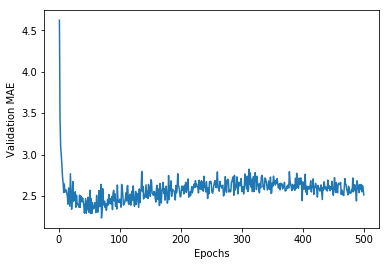

In [17]:
plt.plot(range(1, len(average_mae_history) + 1 ), average_mae_history)

plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

# Plotting Validation Scores - Excluding the first 10 data points

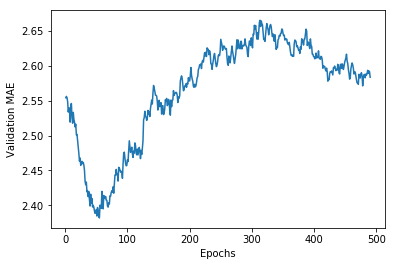

In [15]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1- factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# Training the final model

In [19]:
model = build_model()

#Training on Entire Data
model.fit(train_data, train_targets, epochs = 80, batch_size = 16, verbose = 1)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

Epoch 1/80
404/404 [==============================] - 1s 1ms/step - loss: 502.0387 - mean_absolute_error: 20.1558
Epoch 2/80
404/404 [==============================] - 0s 89us/step - loss: 361.8863 - mean_absolute_error: 16.3567
Epoch 3/80
404/404 [==============================] - 0s 78us/step - loss: 198.9892 - mean_absolute_error: 11.7038
Epoch 4/80
404/404 [==============================] - 0s 113us/step - loss: 84.9680 - mean_absolute_error: 7.1311
Epoch 5/80
404/404 [==============================] - 0s 93us/step - loss: 45.1654 - mean_absolute_error: 4.9302
Epoch 6/80
404/404 [==============================] - 0s 97us/step - loss: 30.8505 - mean_absolute_error: 3.9766
Epoch 7/80
404/404 [==============================] - 0s 77us/step - loss: 24.5771 - mean_absolute_error: 3.5305
Epoch 8/80
404/404 [==============================] - 0s 68us/step - loss: 20.9695 - mean_absolute_error: 3.2906
Epoch 9/80
404/404 [==============================] - 0s 117us/step - loss: 18.6570 - mean

In [20]:
test_mse_score

18.08304880179611